In [97]:
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fiona as fio
import shapely as shp  
#import gdal as gd
from owslib.wfs import WebFeatureService

import requests
import geojson as gs
import json

In [ ]:
'''
county_border = "data/gis/polygon/GastonCounty2020.shp"

bedrock = "data/gis/polygon/geology.shp", online 

bedrock_CRS = "EPSG:32119 - NAD83 / North Carolina"

sampling_points = "data/gis/point/ar_samples_points.csv"

point_crs = "EPSG:4269 Name:NAD83"


universal_crs = "EPSG:4269 Name:NAD83"

'''






## Converting CSV of Well Samples to Point Shapefile

In [153]:
# read in point data
df = pd.read_csv("data/gis/point/ar_samples_points.csv")

# convert arsenic samples to geodataframe

gdf_ar = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs="EPSG:4269")

In [148]:
# check crs
gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [11]:
# Inspect the properties
print(type(gdf_ar), len(gdf_ar))

<class 'geopandas.geodataframe.GeoDataFrame'> 726


## Obtaining Gaston County Boundary

In [136]:
# Read in the county border from NC OneMap API

url = "https://services1.arcgis.com/YBWrN5qiESVpqi92/arcgis/rest/services/ncgs_state_county_boundary/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"

cnty = requests.get(url).json()

In [137]:
# extract a single feature from the cnty json, where the County key within that feature is Gaston

for i in range(len(cnty['features'])):
    if cnty['features'][i]['attributes']['County'] == 'Gaston':
        cnty['features'] = cnty['features'][i]
        break

In [138]:

# get the extent of the county

extent = cnty['features']['geometry']['rings'][0]

# convert to a shapely polygon

poly = shp.geometry.Polygon(extent)

# convert to a geodataframe

gdf_cnty = gpd.GeoDataFrame(geometry=gpd.GeoSeries(poly), crs="EPSG:4269")


In [82]:

# check crs

gdf_cnty.crs


<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [128]:
# plot the county and the points

def basic_map(gdf1, gdf2):

    fig, ax = plt.subplots(figsize=(10,10))

    gdf1.plot(ax=ax, color='none', edgecolor='black')

    gdf2.plot(ax=ax, color='red')

    plt.show()

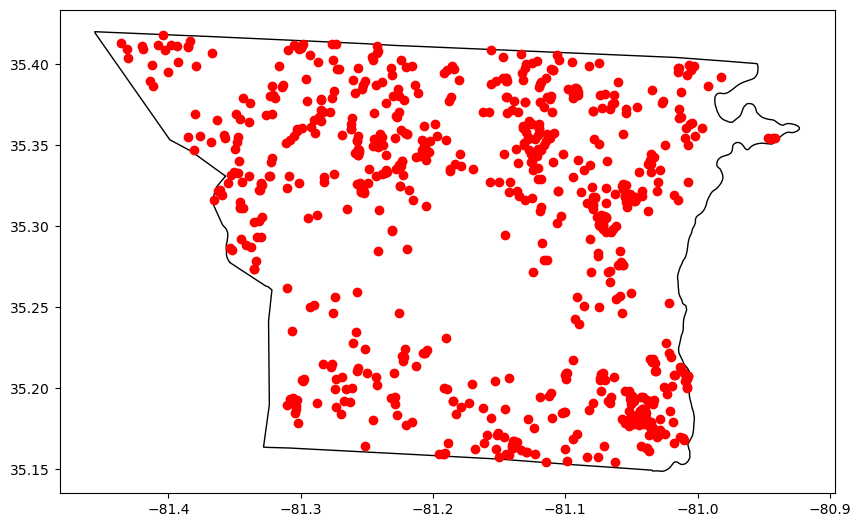

In [129]:
basic_map(gdf_cnty, gdf_ar)

## Obtaining Geology Data

In [154]:
# import geology data from geojson on NC OneMap API

# Put the url in a variable
url = "https://services.nconemap.gov/secure/rest/services/NC1Map_Geological/MapServer/2/query?outFields=*&where=1%3D1&f=geojson"

# Get the data

geol = requests.get(url).json()

# convert to geodataframe

gdf_geol = gpd.GeoDataFrame.from_features(geol)


gdf_geol.crs = 4269


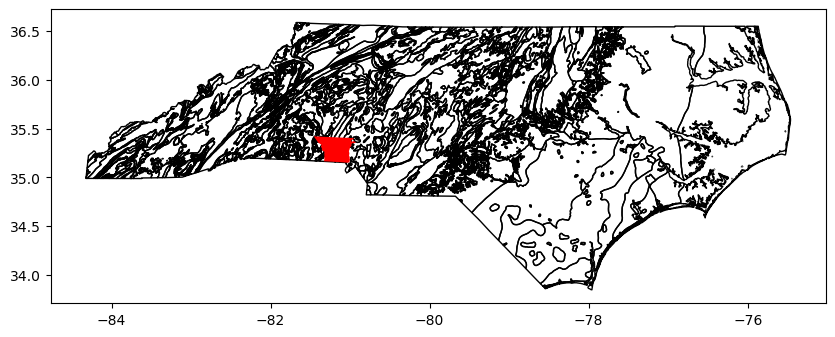

In [131]:
basic_map(gdf_geol, gdf_cnty)

In [155]:
# clip the geology data to the county boundary

gdf_geol = gpd.clip(gdf_geol, gdf_cnty)

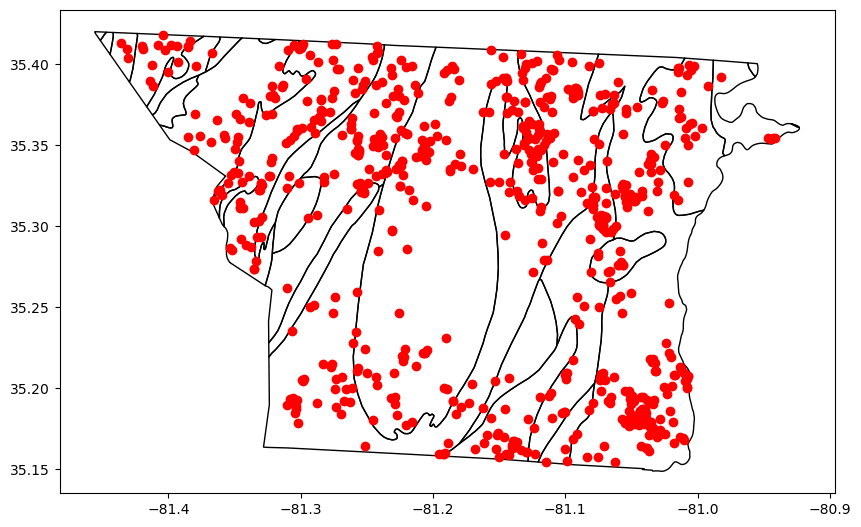

In [156]:
basic_map(gdf_geol_cnty, gdf_ar)

## Merge bedrock type to wells

In [157]:
# check column names from geology important for modeling
# values assessible here https://www.nconemap.gov/datasets/nconemap::geology/about

gdf_geol.columns

Index(['geometry', 'st_area(shape)', 'st_perimeter(shape)', 'objectid',
       'geol250_id', 'geocode', 'belt', 'belt2', 'group_', 'type', 'formation',
       'eon', 'era', 'period', 'abs_age', 'ref_num', 'leg_num', 'shape_leng',
       'descrip_1', 'descrip_2', 'poly_count', 'primary_r', 'primary_g',
       'primary_b', 'pattern', 'pattern_r', 'pattern_g', 'pattern_b',
       'pat_angle', 'pat_angle2', 'pat_angle3', 'plinewdth', 'plinewdth2',
       'plinewdth3', 'patt_separ', 'patoffset', 'patoffset2', 'patcomment',
       'mapunit'],
      dtype='object')

In [158]:
# build index of column names for retaining after spatial join

columns = list(gdf_ar.columns)

geol_columns = ['geocode', 'belt2','type']

columns.extend(geol_columns)

columns

['id',
 'full_add',
 'year_built',
 'date_sampled',
 'year_sampled',
 'X',
 'Y',
 'ar',
 'group',
 'group_five',
 'depth',
 'ph',
 'geometry',
 'geocode',
 'belt2',
 'type']

In [162]:
# Join the bedrock type, "geocode", from the gdf_geol to each well sample point, from gdf_ar, 
# based on the polygon from gdf_geol they lie within

gdf_ar = gpd.sjoin(gdf_ar, gdf_geol, how='left', op='within')


c:\Users\kendall\anaconda3\envs\pygis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [163]:

# drop unneeded columns

gdf_ar = gdf_ar[columns]


In [164]:
gdf_ar3.head()

,id,full_add,year_built,date_sampled,year_sampled,X,Y,ar,group,group_five,depth,ph,geometry,geocode,belt2,type
0,159,"152 HALL RD, GASTONIA, NC 28056",1989.0,2019-09-22,2019.0,-81.102961,35.306266,0.0,0.0,0.0,265.0,7.4,POINT (-81.10296 35.30627),Zbt,Kings Mountain Belt,Metamorphic Rocks
1,163,"105 FALLING LEAF LN, MT HOLLY, NC 28120",1989.0,2019-09-08,2019.0,-81.068957,35.305292,0.0,0.0,0.0,67.0,6.5,POINT (-81.06896 35.30529),CZfv,Charlotte Belt,Metamorphic Rocks
2,182,"211 WILLDON CT, GASTONIA, NC 28056",1989.0,2019-01-14,2019.0,-81.088280,35.320927,0.0,0.0,0.0,225.0,7.1,POINT (-81.08828 35.32093),Zbt,Kings Mountain Belt,Metamorphic Rocks
3,204,"1015 ELIZABETH DR, DALLAS, NC 28034",1989.0,2011-12-19,2011.0,-81.240234,35.356966,0.0,0.0,0.0,250.0,0.0,POINT (-81.24023 35.35697),CZbl,Kings Mountain Belt,Metamorphic Rocks
4,206,"529 ANTHONY GROVE RD, CROUSE, NC 28033",1989.0,2014-06-12,2014.0,-81.321470,35.386198,0.0,0.0,0.0,110.0,7.1,POINT (-81.32147 35.38620),Mc,Inner Piedmont,Intrusive Rocks


In [165]:
# write the geo dataframes to geojson files

gdf_geol.to_file(filename='data/gis/polygon/geology.geojson', driver='GeoJSON')
gdf_ar.to_file(filename='data/gis/point/ar_samples_w_geol.geojson', driver='GeoJSON')
gdf_cnty.to_file(filename='data/gis/polygon/county.geojson', driver='GeoJSON')